## Dependencies

In [1]:
import os
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numpy as np
from torch.utils.data import DataLoader, Dataset
from src.model3 import MobileNetV3UNet
import torch
import torchvision.transforms.functional as TF
from src.utils import test_performance,visualize_test_predictions
from src.model6 import PretrainedUNETR
from src.model1 import UNet
from torchsummary import summary
from ptflops import get_model_complexity_info

## Global parameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(42)
batch_size = 16
lr = 1e-3
num_epochs = 500


# -- Change this as per your data directory --#
data_path = Path('C:\Projects\python\echoframe\data\EchoNet-Dynamic\EchoNet-Dynamic\\')


file_list_path = os.path.join(data_path,'FileList.csv')

#--Model1--#
log_path_1 = Path('./logs/train_log_unet_1.csv')
model_path_1 = Path('./models/model1/best_model1.pt')

#--Model3--#
model_path_3 = Path('./models/model3/best_model1.pt')
log_path_3 = Path('./logs/train_log_mobilenet_1.csv')

#--Model6--#
log_path_6 = Path('./logs/train_log_unetr_1.csv')
model_path_6 = Path('./models/model6/best_model1.pt')


volume_tracings_path = os.path.join(data_path,'VolumeTracings.csv')
videos_path = os.path.join(data_path,'Videos')

<>:27: SyntaxWarning: invalid escape sequence '\P'
<>:27: SyntaxWarning: invalid escape sequence '\P'
C:\Users\harsh\AppData\Local\Temp\ipykernel_11548\2918946629.py:27: SyntaxWarning: invalid escape sequence '\P'
  data_path = Path('C:\Projects\python\echoframe\data\EchoNet-Dynamic\EchoNet-Dynamic\\')
c:\Projects\python\echoframe_capstone\mainenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utils

In [2]:
def build_polygons_dict(volume_csv_path):
    """
    Gathers partial tracing rows from VolumeTracings.csv into a dict:
      (base_name, frame_number) -> [ [(x1,y1), (x2,y2), ... ] ]
    """
    tracings_df = pd.read_csv(volume_csv_path)
    
    grouped = tracings_df.groupby(["FileName", "Frame"])
    polygons_dict = {}
    for (filename, frame), group_rows in grouped:
        coords = []
        for _, row in group_rows.iterrows():
            x1, y1 = float(row["X1"]), float(row["Y1"])
            x2, y2 = float(row["X2"]), float(row["Y2"])
            coords.append((x1, y1))
            coords.append((x2, y2))

        base_name = os.path.splitext(filename)[0]
        key = (base_name, int(frame))
        polygons_dict[key] = [coords]
    return polygons_dict

def sort_polygon_coords(coords):
    """
    Sort (x,y) points by angle around the centroid, forming a continuous path.
    """
    centroid = np.mean(coords, axis=0)
    angles = [np.arctan2(y - centroid[1], x - centroid[0]) for (x, y) in coords]
    sorted_idx = np.argsort(angles)
    return [coords[i] for i in sorted_idx]

def create_mask(polygons_dict, video_name, frame_idx, hw_shape):
    """
    Builds a binary 2D mask of shape hw_shape for (video_name, frame_idx).
    Applies a morphological 'close' to fill small holes/gaps.
    Returns a mask in range {0,1}.
    """
    base_name = os.path.splitext(video_name)[0]
    key = (base_name, frame_idx)

    mask = np.zeros(hw_shape, dtype=np.uint8)
    if key not in polygons_dict:
        return mask  # No polygons => empty mask

    for polygon_coords in polygons_dict[key]:
        coords_sorted = sort_polygon_coords(polygon_coords)
        pts = np.array(coords_sorted, dtype=np.int32).reshape((-1, 1, 2))
        cv2.fillPoly(mask, [pts], 255)

    # Morphological closing to fill holes
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    mask = (mask > 127).astype(np.uint8)
    return mask

def read_frame_resized(video_path, frame_idx, resize=(112, 112)):
    """
    Reads the 0-based frame_idx from the video, converts BGR->RGB,
    and resizes to (width,height) if desired. Returns (H,W,3) in RGB.
    If the read fails, returns None.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    cap.release()

    if not ret or frame is None:
        return None

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    if resize is not None:
        w, h = resize  # (width, height)
        frame = cv2.resize(frame, (w, h), interpolation=cv2.INTER_AREA)
    return frame

class EchoMaskDataset(Dataset):
    def __init__(self, 
                 df,                
                 polygons_dict,     
                 videos_path,       
                 transform=None,    
                 resize=(112, 112),
                 all_traced_frames=True,
                 offset_frames_by_one=False):

        self.df = df.reset_index(drop=True)
        self.polygons_dict = polygons_dict
        self.videos_path = videos_path
        self.transform = transform
        self.resize = resize
        self.all_traced_frames = all_traced_frames
        self.offset_frames_by_one = offset_frames_by_one

        # 1) Build list of (FileName, frame_idx) samples
        self.samples = []
        
        # Convert polygons_dict keys to a list of (BaseName, Frame)
        all_keys = list(polygons_dict.keys())
        base_frames_map = {}
        for (bn, fr) in all_keys:
            if bn not in base_frames_map:
                base_frames_map[bn] = []
            base_frames_map[bn].append(fr)

        # 2) For each file in df, gather frames from base_frames_map
        for _, row in self.df.iterrows():
            file_name = row["FileName"]  # e.g. 0X100009310A3BD7FC.avi
            base_name = os.path.splitext(file_name)[0]

            if base_name not in base_frames_map:
                continue  # no annotated frames for this file

            frames_this_file = base_frames_map[base_name]

            if len(frames_this_file) == 0:
                continue

            if self.all_traced_frames:
                for fr in frames_this_file:
                    self.samples.append((file_name, fr))
            else:
                es_frame = min(frames_this_file)
                ed_frame = max(frames_this_file)
                self.samples.append((file_name, es_frame))
                if ed_frame != es_frame:
                    self.samples.append((file_name, ed_frame))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_name, frame_idx = self.samples[idx]
        video_path = os.path.join(self.videos_path, file_name)

        # If your VolumeTracings.csv is 1-based and OpenCV expects 0-based,
        # offset frames by 1
        if self.offset_frames_by_one:
            frame_idx -= 1
            if frame_idx < 0:
                frame_idx = 0

        # 1) Load the image => shape (H,W,3)
        image_np = read_frame_resized(video_path, frame_idx, resize=self.resize)
        if image_np is None:
            # If something fails, fallback to black image
            w, h = self.resize
            image_np = np.zeros((h, w, 3), dtype=np.uint8)

        # 2) Create the mask => shape (H,W)
        mask_np = create_mask(
            polygons_dict=self.polygons_dict,
            video_name=file_name,
            frame_idx=frame_idx,
            hw_shape=image_np.shape[:2]  # (H,W)
        )

        # mask_np is 0 or 1 => shape (H,W)
        # Expand to (H,W,1)
        mask_np = np.expand_dims(mask_np, axis=-1)

        # 3) Convert to PyTorch Tensors, reorder to CHW
        # image: (3,H,W), mask: (1,H,W)
        image_tensor = torch.from_numpy(image_np).permute(2,0,1).float() / 255.0
        mask_tensor  = torch.from_numpy(mask_np).permute(2,0,1).float()

        # 4) Optional transforms
        if self.transform is not None:
            image_tensor, mask_tensor = self.transform(image_tensor, mask_tensor)

        return image_tensor, mask_tensor,file_name

## Load Data

In [3]:
file_list = pd.read_csv(filepath_or_buffer=file_list_path)
volume_tracings = pd.read_csv(filepath_or_buffer=volume_tracings_path)


file_list['FileName'] = file_list['FileName'].apply(
    lambda x: x if x.endswith('.avi') else x + '.avi'
)
vt_filenames = set(volume_tracings['FileName'])
fl_filenames = set(file_list['FileName'])

missing_files = list(fl_filenames - vt_filenames)
extra_files = list(vt_filenames - fl_filenames)

print(f'Missing files: \n{missing_files}\n\nExtra files: \n{extra_files}')
redacted_files = missing_files+extra_files

file_list = file_list[~file_list['FileName'].isin(redacted_files)]
volume_tracings = volume_tracings[~volume_tracings['FileName'].isin(redacted_files)]

test_df  = file_list[file_list['Split'] == 'TEST']

Missing files: 
['0X5515B0BD077BE68A.avi', '0X6C435C1B417FDE8A.avi', '0X5DD5283AC43CCDD1.avi', '0X35291BE9AB90FB89.avi', '0X2DC68261CBCC04AE.avi', '0X234005774F4CB5CD.avi']

Extra files: 
['0X4F8859C8AB4DA9CB.avi']


In [4]:
polygons_dict = build_polygons_dict(volume_tracings_path)
test_dataset = EchoMaskDataset(
    df=test_df,
    polygons_dict=polygons_dict,
    videos_path=videos_path,
    transform=None,         # or pass a custom transform
    resize=(112, 112),
    all_traced_frames=True, # if you want *all* traced frames
    offset_frames_by_one=False
)

test_loader = DataLoader(test_dataset,batch_size=2)


## Predict

### UNet

In [6]:
model_1=UNet()
test_performance(model=model_1,
                 test_loader=test_loader,
                 test_df=test_df,
                 device=device,
                 model_path=model_path_1)


Test Loss (segmentation): 0.12229831225959858
Test Dice (segmentation): 0.926921969343876
EF Mean Absolute Error (MAE): 7.018255305134377
EF Mean Absolute Percentage Error (MAPE): 13.90841835873886%


In [7]:
summary(model_1,(3, 112, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,792
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          36,928
       BatchNorm2d-5         [-1, 64, 112, 112]             128
              ReLU-6         [-1, 64, 112, 112]               0
        Conv_block-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
           Encoder-9  [[-1, 64, 112, 112], [-1, 64, 56, 56]]               0
           Conv2d-10          [-1, 128, 56, 56]          73,856
      BatchNorm2d-11          [-1, 128, 56, 56]             256
             ReLU-12          [-1, 128, 56, 56]               0
           Conv2d-13          [-1, 128, 56, 56]         147,584
      BatchNorm2d-14      

In [8]:
macs, params = get_model_complexity_info(
    model_1,
    (3, 112, 112),
    as_strings=False,
    print_per_layer_stat=False,
    verbose=False
)

# convert MACs -> FLOPs -> GFLOPs
flops = 2.0 * macs  # 1 MAC = 2 FLOPs (multiply + add)
gflops = flops / 1e9
print(f"GFLOPs (ptflops): {gflops:.2f}")

GFLOPs (ptflops): 20.98


### UNetR

In [9]:
model_6=PretrainedUNETR()
test_performance(model=model_6,
                 test_loader=test_loader,
                 test_df=test_df,
                 device=device,
                 model_path=model_path_6)

Test Loss (segmentation): 0.15032551867075755
Test Dice (segmentation): 0.9108766296230326
EF Mean Absolute Error (MAE): 7.923632640984626
EF Mean Absolute Percentage Error (MAPE): 15.488431524620893%


In [10]:
summary(model_6,(3, 112, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 768, 7, 7]         590,592
          Identity-2              [-1, 49, 768]               0
        PatchEmbed-3              [-1, 49, 768]               0
         LayerNorm-4              [-1, 49, 768]           1,536
            Linear-5             [-1, 49, 2304]       1,771,776
          Identity-6           [-1, 12, 49, 64]               0
          Identity-7           [-1, 12, 49, 64]               0
            Linear-8              [-1, 49, 768]         590,592
           Dropout-9              [-1, 49, 768]               0
        Attention-10              [-1, 49, 768]               0
         Identity-11              [-1, 49, 768]               0
         Identity-12              [-1, 49, 768]               0
        LayerNorm-13              [-1, 49, 768]           1,536
           Linear-14             [-1, 4

In [11]:
macs, params = get_model_complexity_info(
    model_6,
    (3, 112, 112),
    as_strings=False,
    print_per_layer_stat=False,
    verbose=False
)

# convert MACs -> FLOPs -> GFLOPs
flops = 2.0 * macs  # 1 MAC = 2 FLOPs (multiply + add)
gflops = flops / 1e9
print(f"GFLOPs (ptflops): {gflops:.2f}")

GFLOPs (ptflops): 30.95


### MobileNetV3 UNet

In [12]:
model_3=MobileNetV3UNet()
test_performance(model=model_3,
                 test_loader=test_loader,
                 test_df=test_df,
                 device=device,
                 model_path=model_path_3)


c:\Projects\python\echoframe_capstone\mainenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Projects\python\echoframe_capstone\mainenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Loss (segmentation): 0.12197059575690185
Test Dice (segmentation): 0.9269558649078058
EF Mean Absolute Error (MAE): 6.74988862830732
EF Mean Absolute Percentage Error (MAPE): 13.377623804173286%


In [13]:
summary(model_3,(3, 112, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 56, 56]             432
            Conv2d-2           [-1, 16, 56, 56]             432
       BatchNorm2d-3           [-1, 16, 56, 56]              32
       BatchNorm2d-4           [-1, 16, 56, 56]              32
         Hardswish-5           [-1, 16, 56, 56]               0
         Hardswish-6           [-1, 16, 56, 56]               0
            Conv2d-7           [-1, 16, 56, 56]             144
            Conv2d-8           [-1, 16, 56, 56]             144
       BatchNorm2d-9           [-1, 16, 56, 56]              32
      BatchNorm2d-10           [-1, 16, 56, 56]              32
             ReLU-11           [-1, 16, 56, 56]               0
             ReLU-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
           Conv2d-14           [-1, 16,

In [14]:
macs, params = get_model_complexity_info(
    model_3,
    (3, 112, 112),
    as_strings=False,
    print_per_layer_stat=False,
    verbose=False
)

# convert MACs -> FLOPs -> GFLOPs
flops = 2.0 * macs  # 1 MAC = 2 FLOPs (multiply + add)
gflops = flops / 1e9
print(f"GFLOPs (ptflops): {gflops:.2f}")

GFLOPs (ptflops): 0.39


## Test Visualizations

### UNet


🔹 Showing Batch 1 (Index: 968)



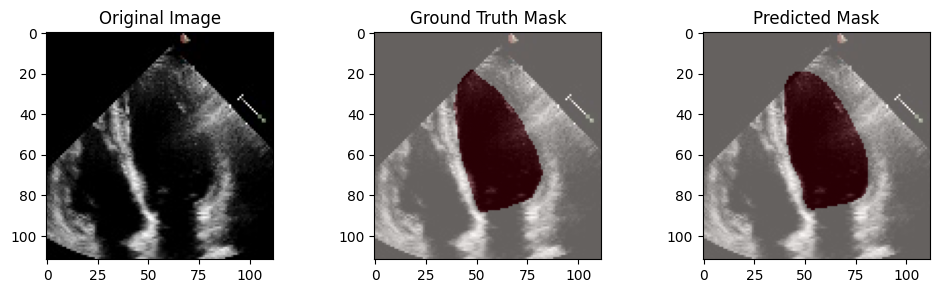

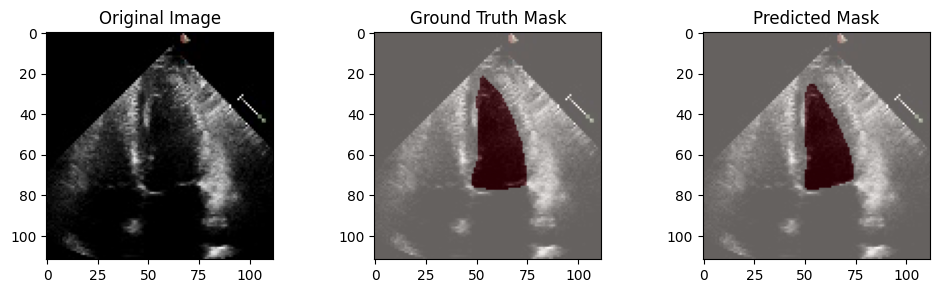


🔹 Showing Batch 2 (Index: 1274)



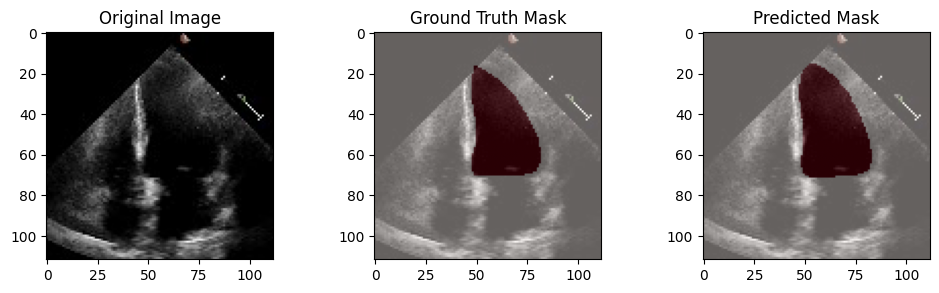

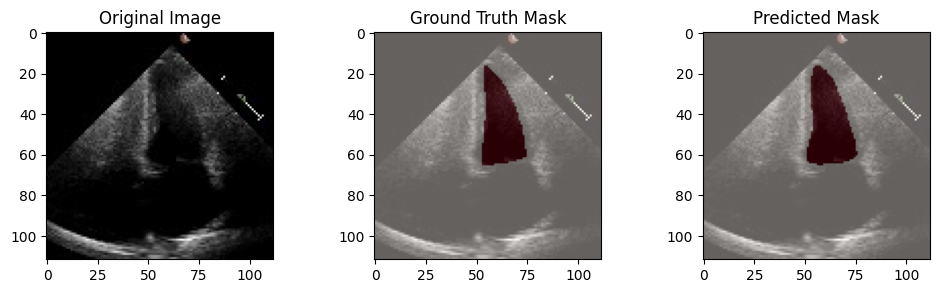


🔹 Showing Batch 3 (Index: 442)



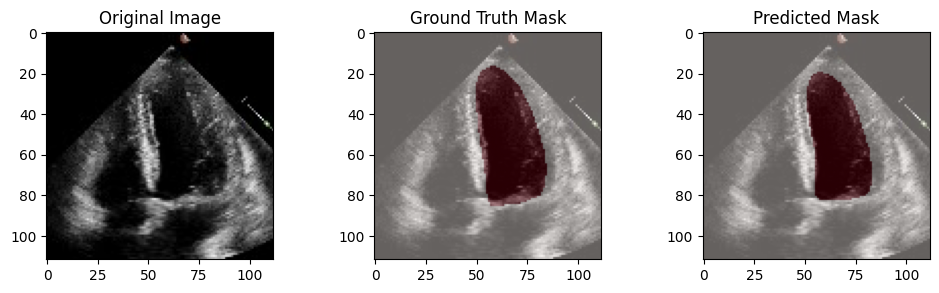

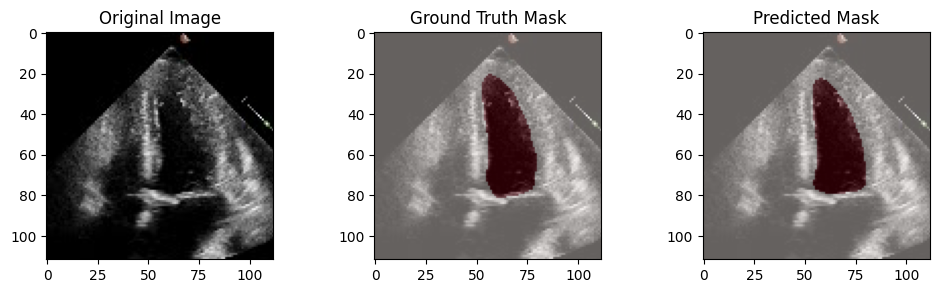


🔹 Showing Batch 4 (Index: 1147)



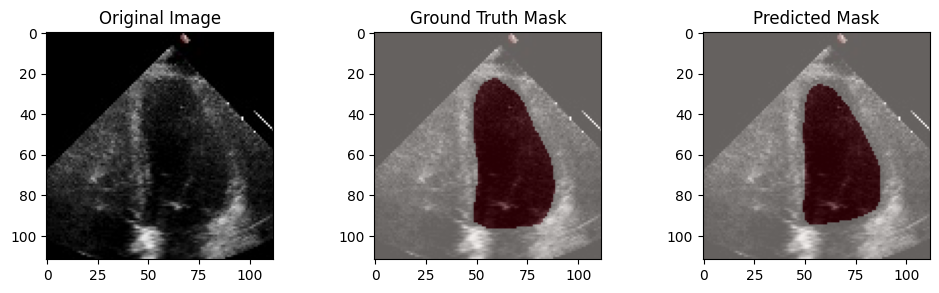

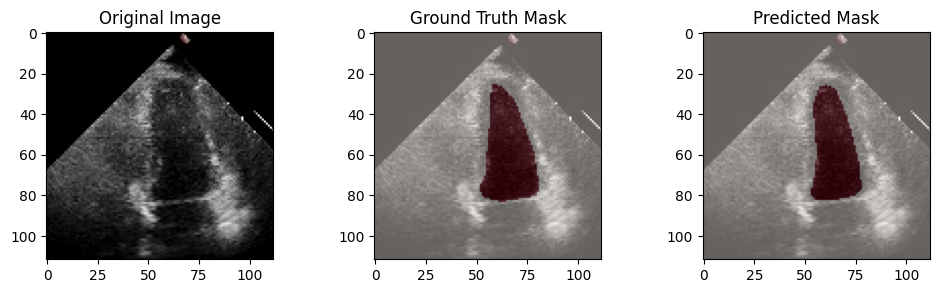


🔹 Showing Batch 5 (Index: 1030)



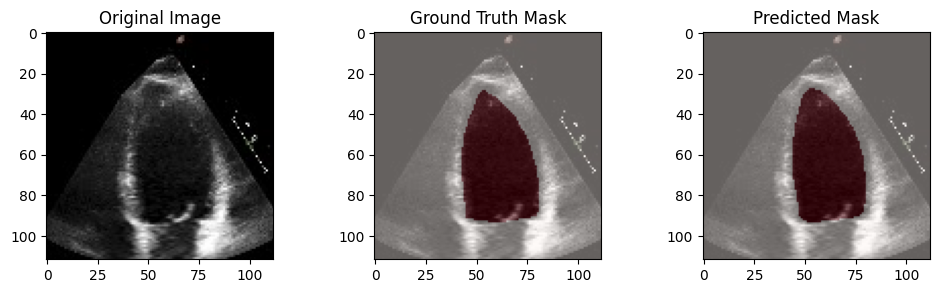

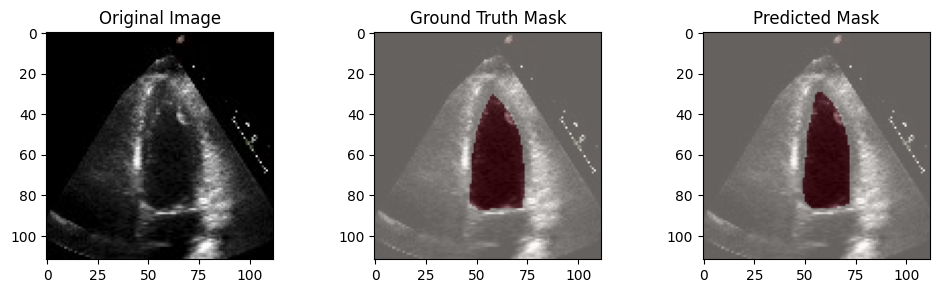

In [ ]:
visualize_test_predictions(model=model_1,test_loader=test_loader,device=device)

### UNetR


🔹 Showing Batch 1 (Index: 112)



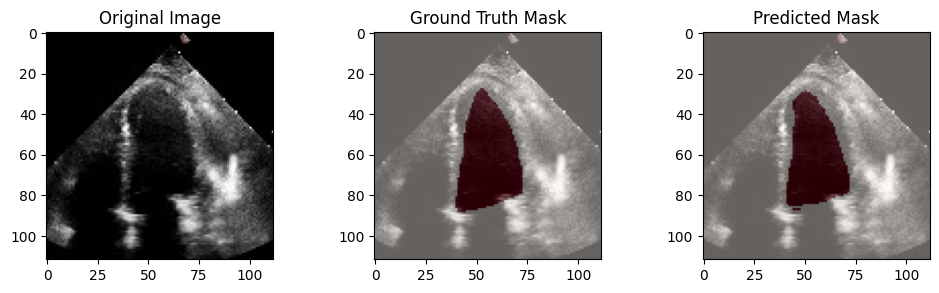

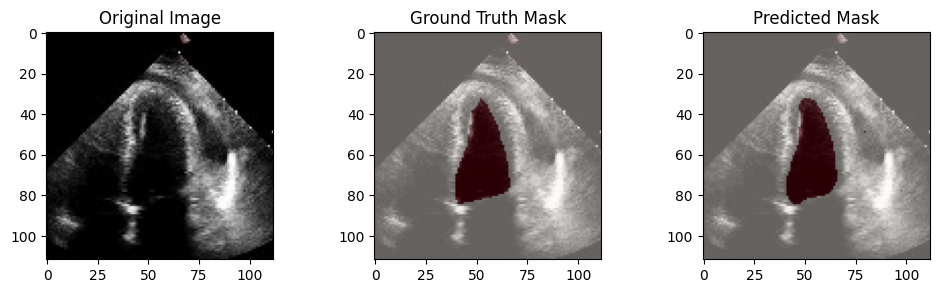


🔹 Showing Batch 2 (Index: 245)



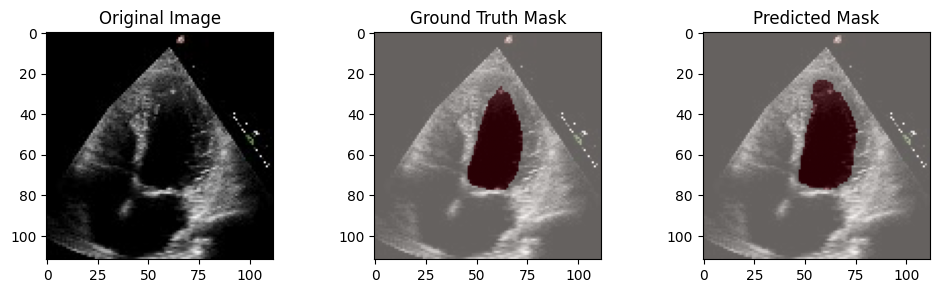

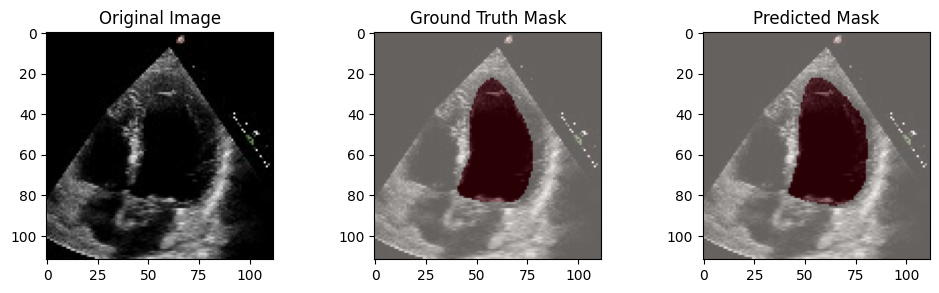


🔹 Showing Batch 3 (Index: 1102)



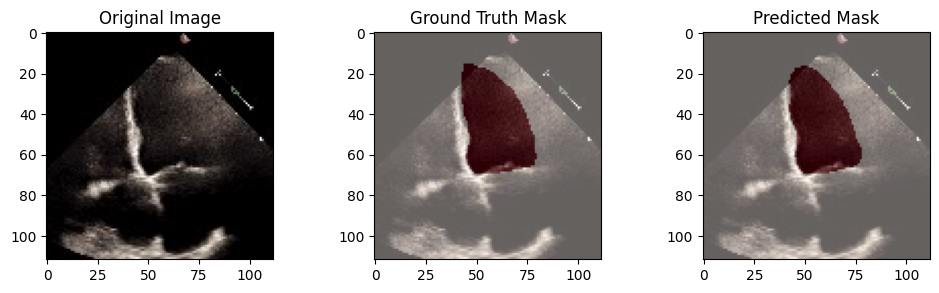

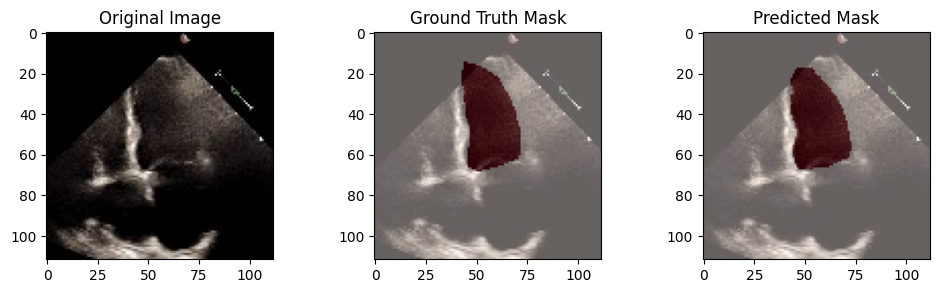


🔹 Showing Batch 4 (Index: 779)



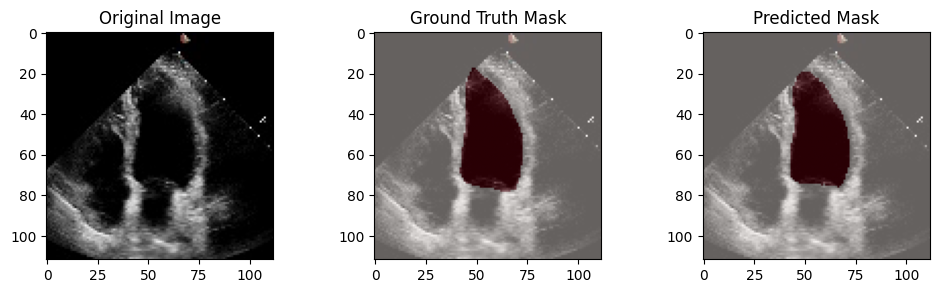

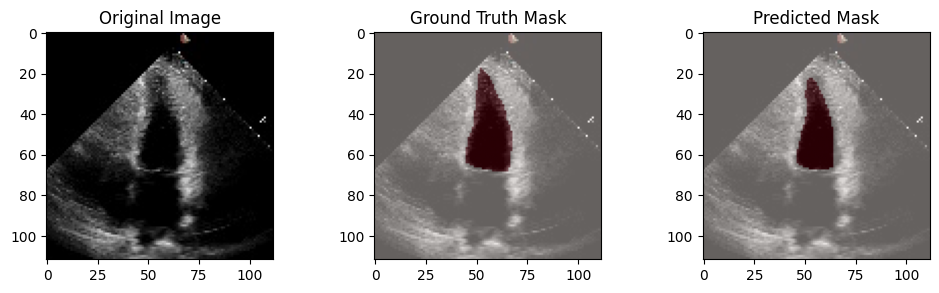


🔹 Showing Batch 5 (Index: 1037)



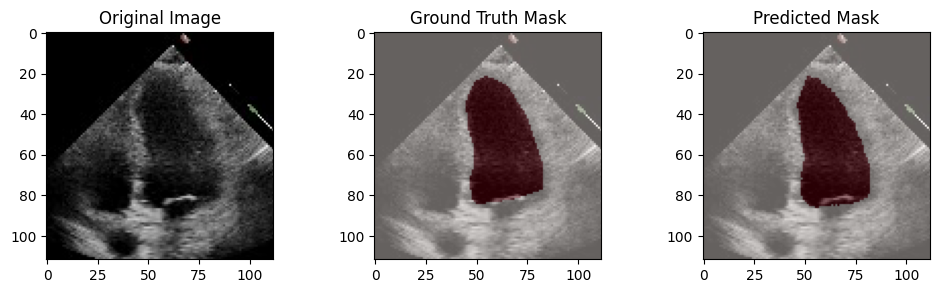

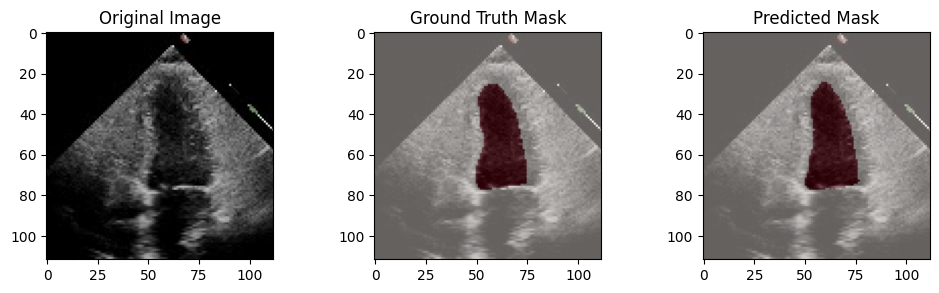

In [ ]:
visualize_test_predictions(model=model_6,test_loader=test_loader,device=device)

### MobileNetV3 UNet


🔹 Showing Batch 1 (Index: 990)



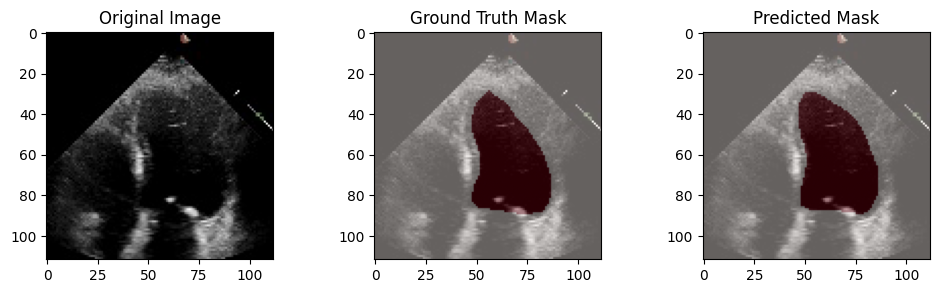

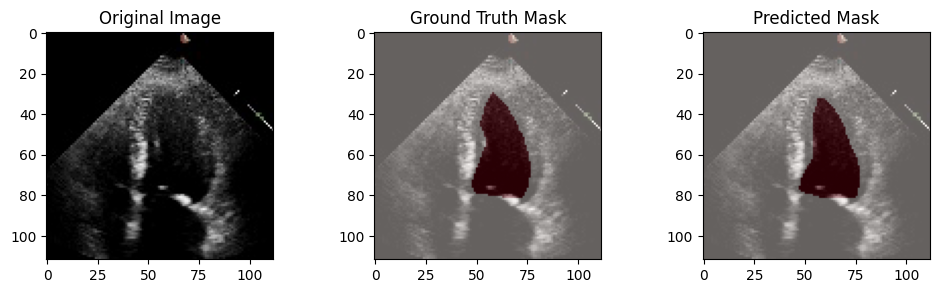


🔹 Showing Batch 2 (Index: 780)



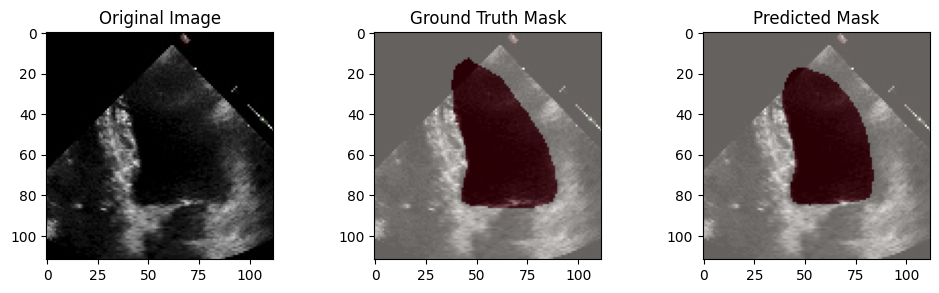

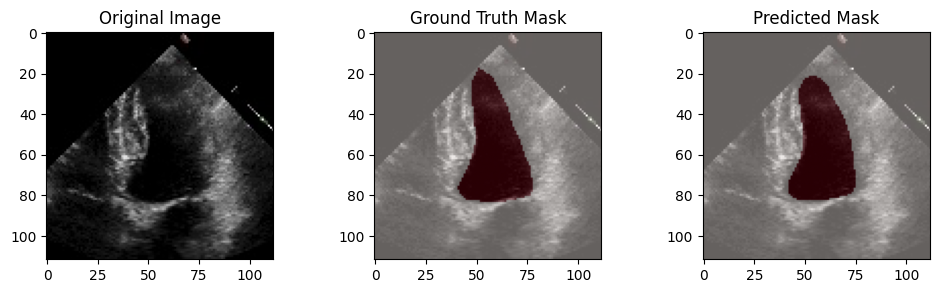


🔹 Showing Batch 3 (Index: 1050)



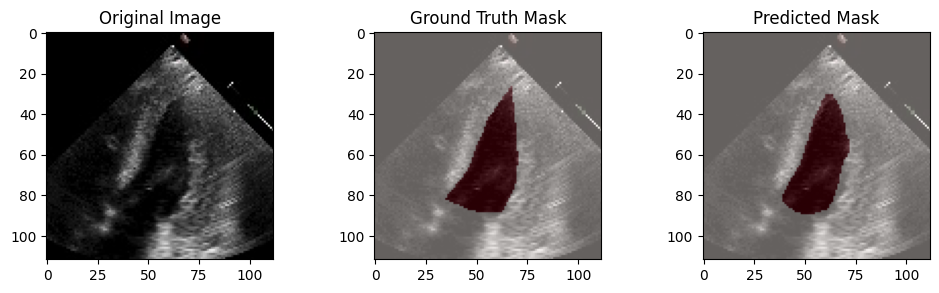

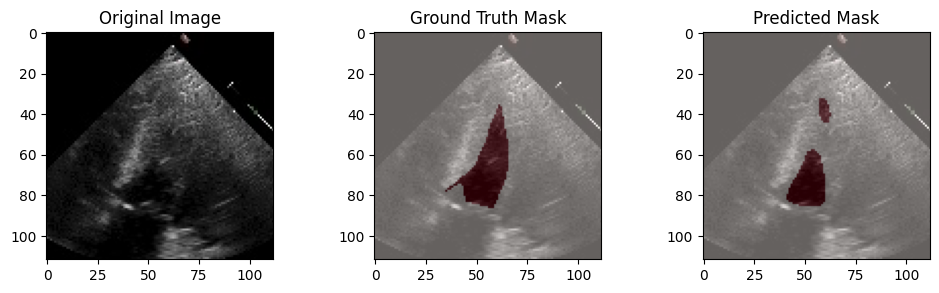


🔹 Showing Batch 4 (Index: 1127)



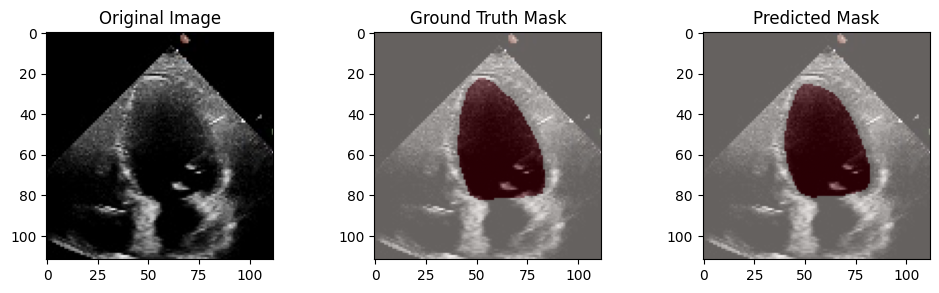

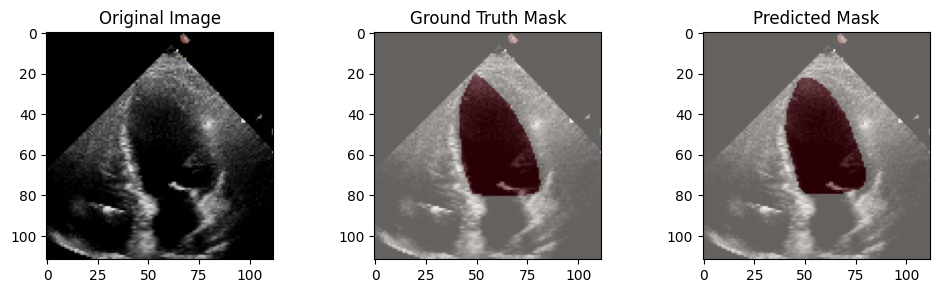


🔹 Showing Batch 5 (Index: 476)



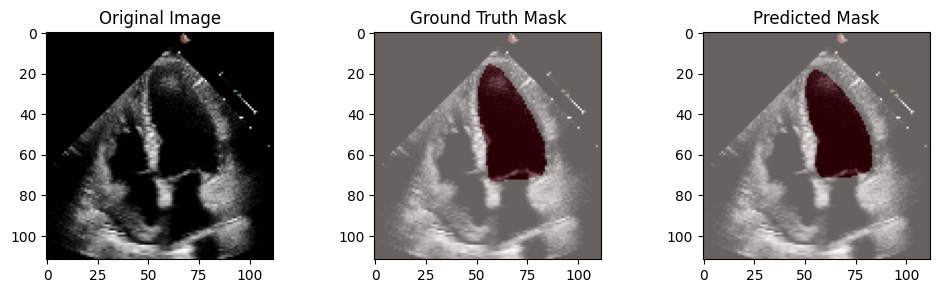

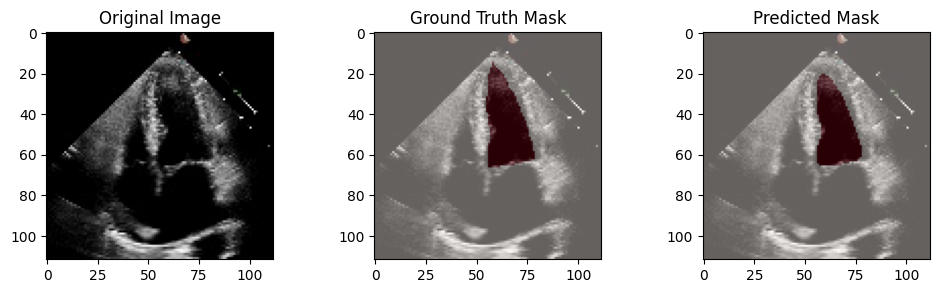

In [ ]:
visualize_test_predictions(model=model_3,test_loader=test_loader,device=device)